<a href="https://colab.research.google.com/github/afshari-maryam/HuggingFace-learning/blob/main/ch2_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.6 MB/s 
     |████████████████████████████████| 182 kB 74.3 MB/s 
     |████████████████████████████████| 7.6 MB 64.8 MB/s 


#behind the pipeline

In [2]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

Preprocessing data like pretrain model in model hub : 
https://huggingface.co/models


all this preprocessing needs to be done in exactly the same way as when the model was pretrained, so we first need to download that information from the Model Hub. To do this, we use the **AutoTokenizer class** and its **from_pretrained() method.** Using the **checkpoint name of our model**, it will automatically fetch the data associated with the model’s tokenizer and cache it (so it’s only downloaded the first time you run the code below).

Since the default **checkpoint** of the sentiment-analysis pipeline is **distilbert-base-uncased-finetuned-sst-2-english** (you can see its model card here), we run the following:

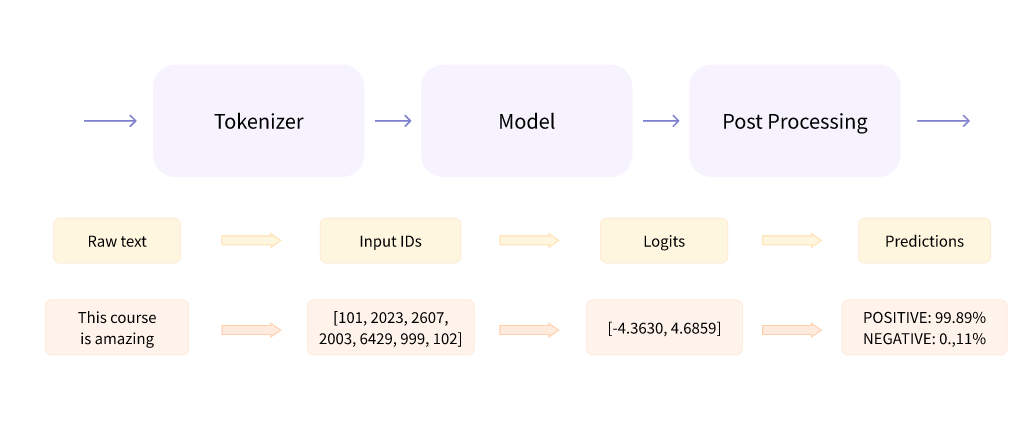

In [5]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [6]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


The output itself is a dictionary containing two keys, input_ids and attention_mask. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence. We’ll explain what the attention_mask is later in this chapter.

**Going through the model**

We can download our pretrained model the same way we did with our tokenizer. 🤗 Transformers provides an AutoModel class which also has a from_pretrained() method:

In [5]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In this code snippet, we have downloaded the same checkpoint we used in our pipeline before (it should actually have been cached already) and instantiated a model with it.

This architecture contains only the base Transformer module: given some inputs, it outputs what we’ll call hidden states, also known as features. For each model input, we’ll retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model.

If this doesn’t make sense, don’t worry about it. We’ll explain it all later.

While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the head. In Chapter 1, the different tasks could have been performed with the same architecture, but each of these tasks will have a different head associated with it.

**A high-dimensional vector?**
The vector output by the Transformer module is usually large. It generally has three dimensions:

**Batch size:** The number of sequences processed at a time (2 in our example).
Sequence length: The length of the numerical representation of the sequence (16 in our example).
**Hidden size:** The vector dimension of each model input.
It is said to be “high dimensional” because of the last value. The hidden size can be very large (768 is common for smaller models, and in larger models this can reach 3072 or more).

We can see this if we feed the inputs we preprocessed to our model:

In [6]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


Note that the outputs of 🤗 Transformers models behave like namedtuples or dictionaries. You can access the elements by attributes (like we did) or by key (outputs["last_hidden_state"]), or even by index if you know exactly where the thing you are looking for is (outputs[0]).



**Model heads:** Making sense out of numbers
The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:



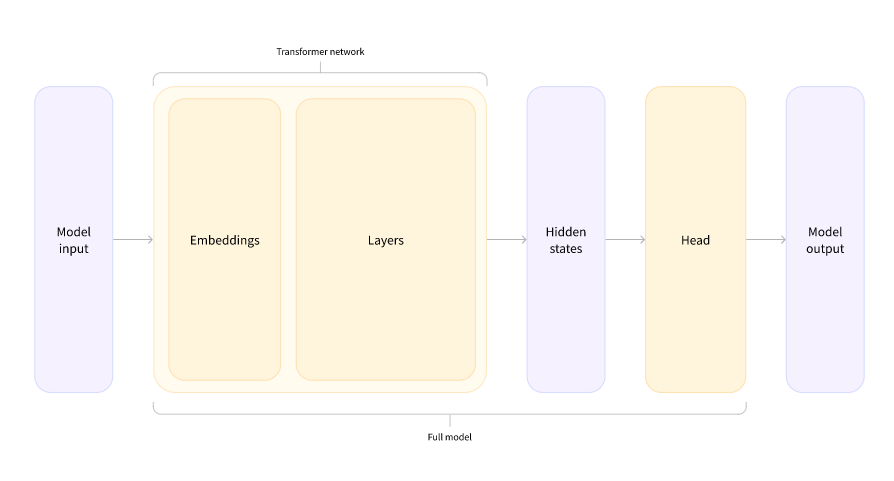

The output of the Transformer model is sent directly to the model head to be processed.

In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

*Model (retrieve the hidden states)
*ForCausalLM
*ForMaskedLM
*ForMultipleChoice
*ForQuestionAnswering
*ForSequenceClassification
*ForTokenClassification
and others 🤗
For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the AutoModel class, but AutoModelForSequenceClassification:

In [7]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [8]:
print(outputs.logits.shape)

torch.Size([2, 2])


Since we have just **two sentences and two labels**, the result we get from our model is of shape 2 x 2.

**Postprocessing the output**


In [9]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


In [10]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [11]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

We have successfully reproduced the three steps of the pipeline: **preprocessing with tokenizers**, **passing the inputs through the model**, and **postprocessing**! Now let’s take some time to dive deeper into each of those steps.

**Test2:**
***This is my attempt......***

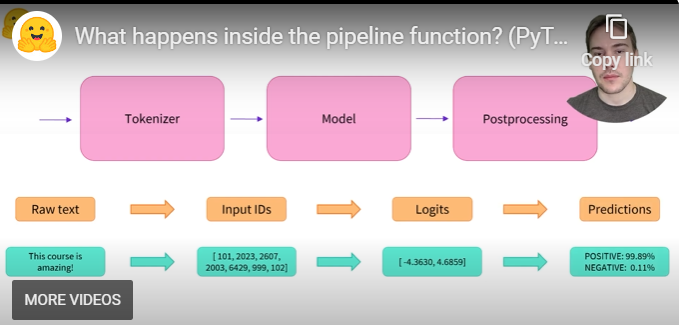

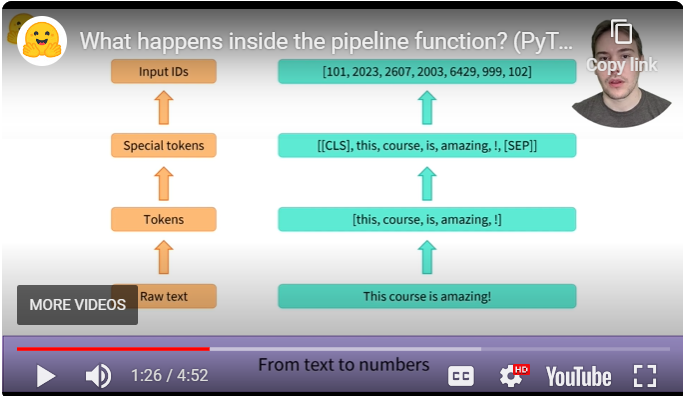

In [12]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [13]:
raw_inputs2 = [
    "I love the life.",
    "I hate the good guy!",
    "I hate the bad words!",
]
inputs2 = tokenizer(raw_inputs2, padding=True, truncation=True, return_tensors="pt")
print(inputs2)

{'input_ids': tensor([[ 101, 1045, 2293, 1996, 2166, 1012,  102,    0],
        [ 101, 1045, 5223, 1996, 2204, 3124,  999,  102],
        [ 101, 1045, 5223, 1996, 2919, 2616,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])}


In [14]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
outputs = model(**inputs2)
print(outputs.last_hidden_state.shape)

torch.Size([3, 8, 768])


In [17]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs2)

In [18]:
print(outputs.logits.shape)

torch.Size([3, 2])


In [19]:
print(outputs.logits)

tensor([[-4.3493,  4.6958],
        [ 3.5518, -2.9149],
        [ 3.0819, -2.5798]], grad_fn=<AddmmBackward0>)


In [20]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[1.1795e-04, 9.9988e-01],
        [9.9845e-01, 1.5521e-03],
        [9.9654e-01, 3.4648e-03]], grad_fn=<SoftmaxBackward0>)


In [21]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

#Models

**Creating a Transformer**

The first thing we’ll need to do to initialize a BERT model is load a configuration object:

In [2]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)

In [3]:
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

# Model is randomly initialized!

In [4]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This model is now initialized with all the weights of the checkpoint. **It can be used directly for inference on the tasks it was trained on, and it can also be fine-tuned on a new task.** By training with pretrained weights rather than from scratch, we can quickly achieve good results.

**Saving methods**

In [5]:
model.save_pretrained("directory_on_my_computer")

In [6]:
!ls directory_on_my_computer

config.json  pytorch_model.bin


If you take a look at the config.json file, you’ll recognize the attributes necessary to build the model architecture. This file also contains some metadata, such as where the checkpoint originated and what 🤗 Transformers version you were using when you last saved the checkpoint.

The **pytorch_model.bin** file is known as the *state dictionary*; it contains all your model’s weights. The two files go hand in hand; the **configuration** is **necessary to know your model’s architecture**, while the **model weights** are** your model’s parameters**.

 **Using a Transformer model for inference**



In [7]:
sequences = ["Hello!", "Cool.", "Nice!"]

In [8]:
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]

In [9]:
import torch

model_inputs = torch.tensor(encoded_sequences)

**Using the tensors as inputs to the model**

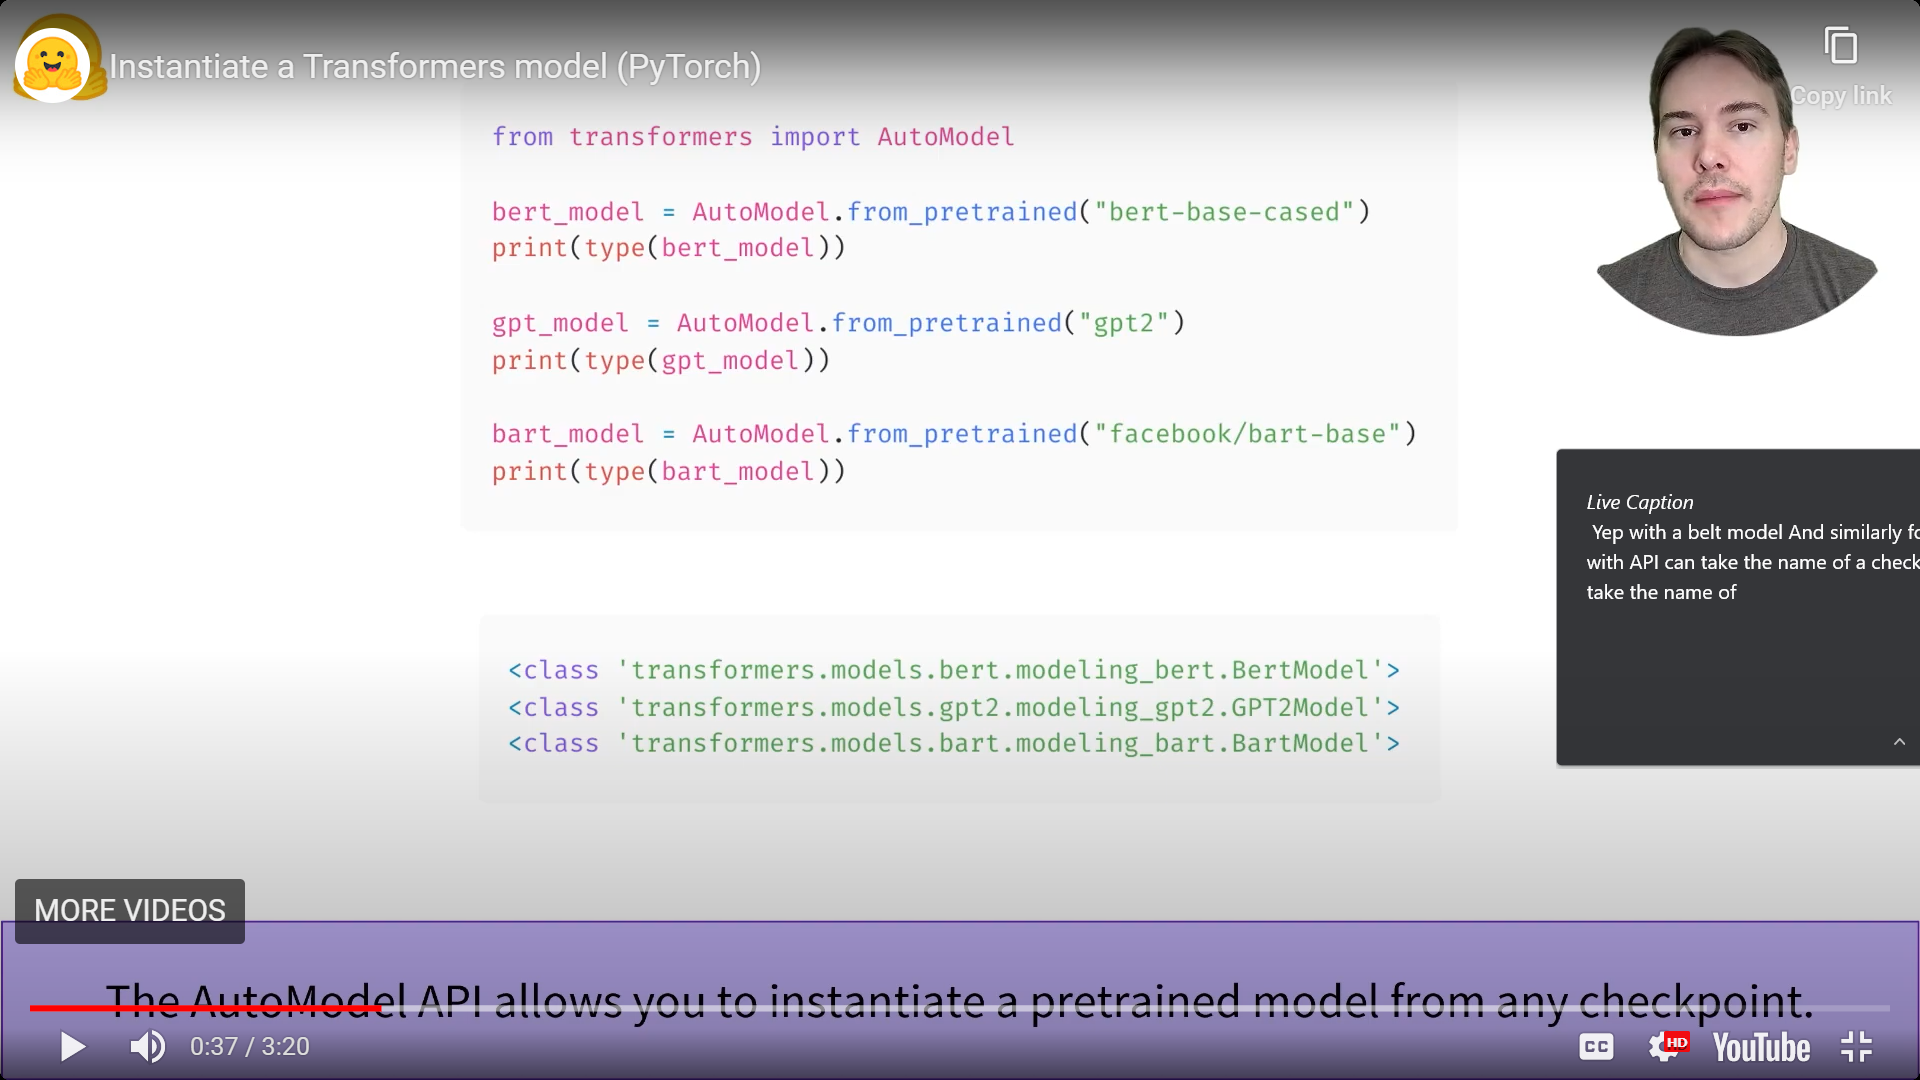

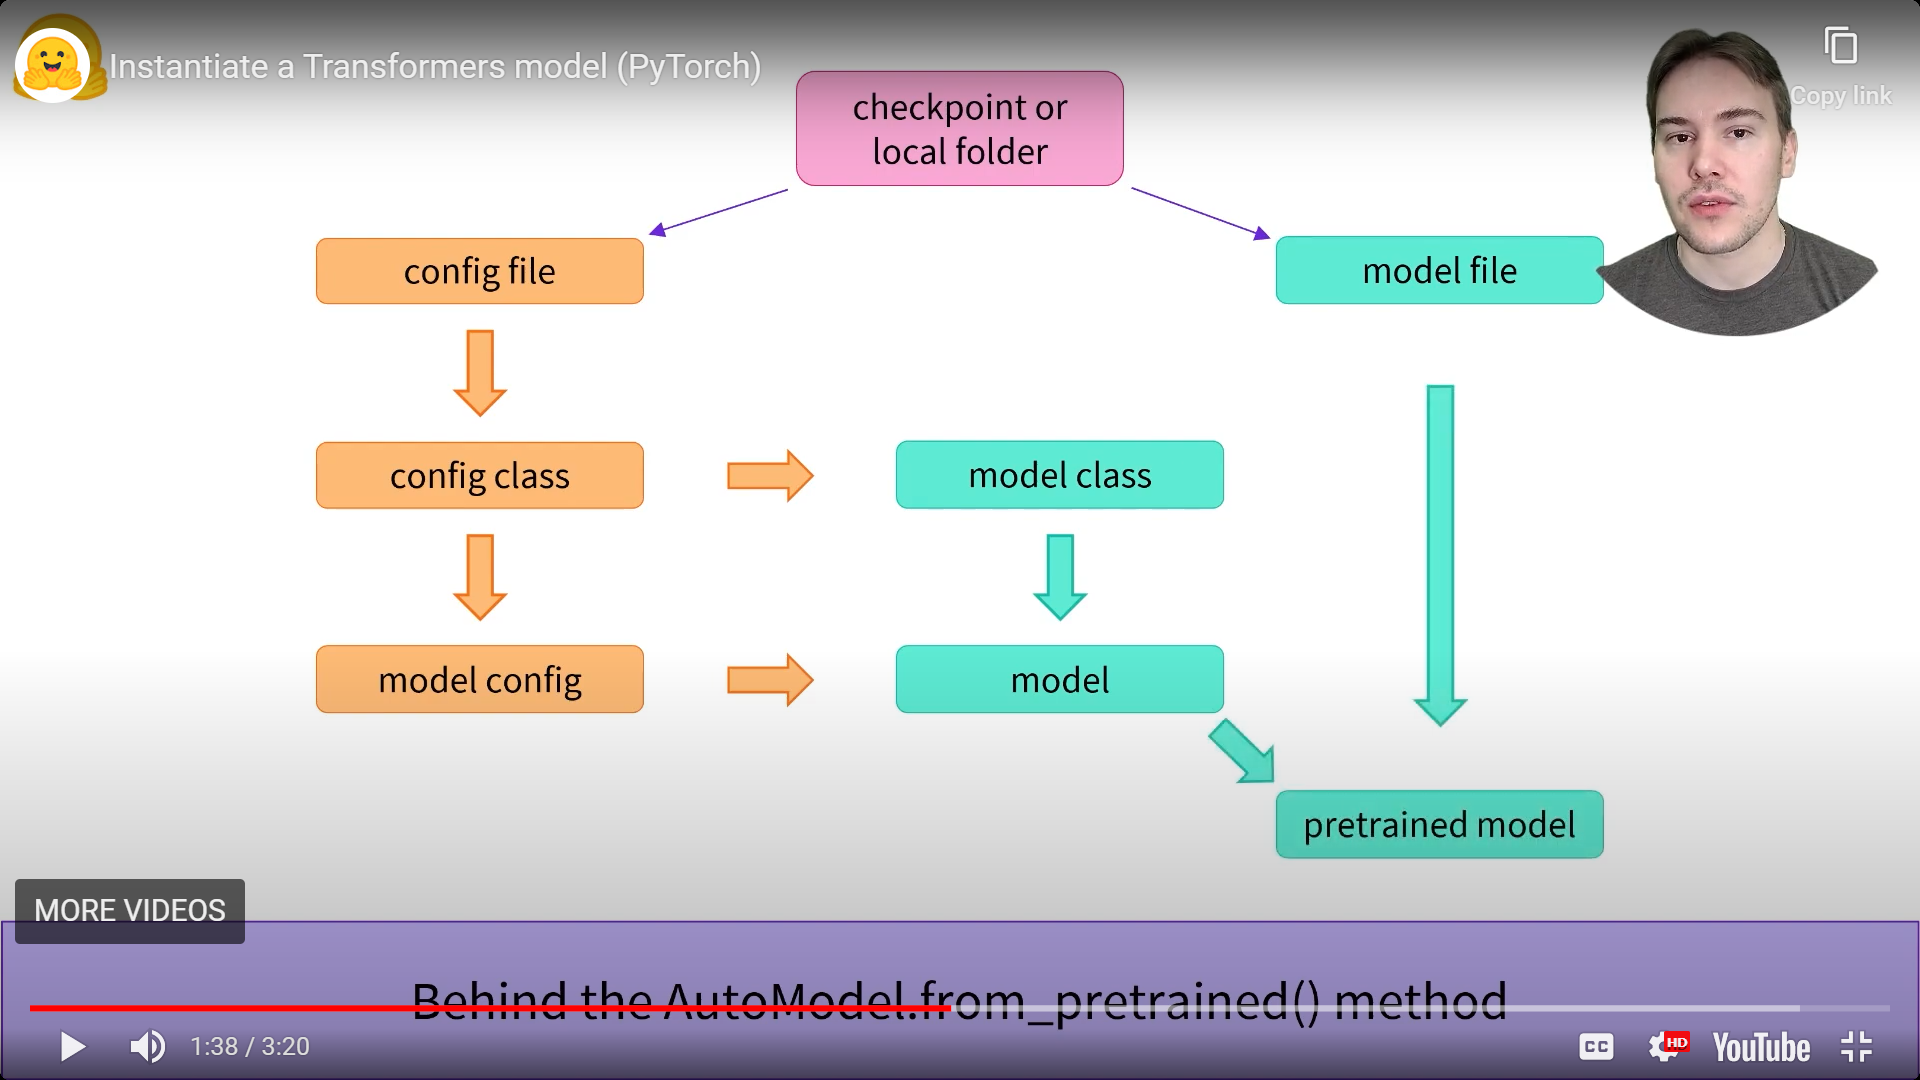

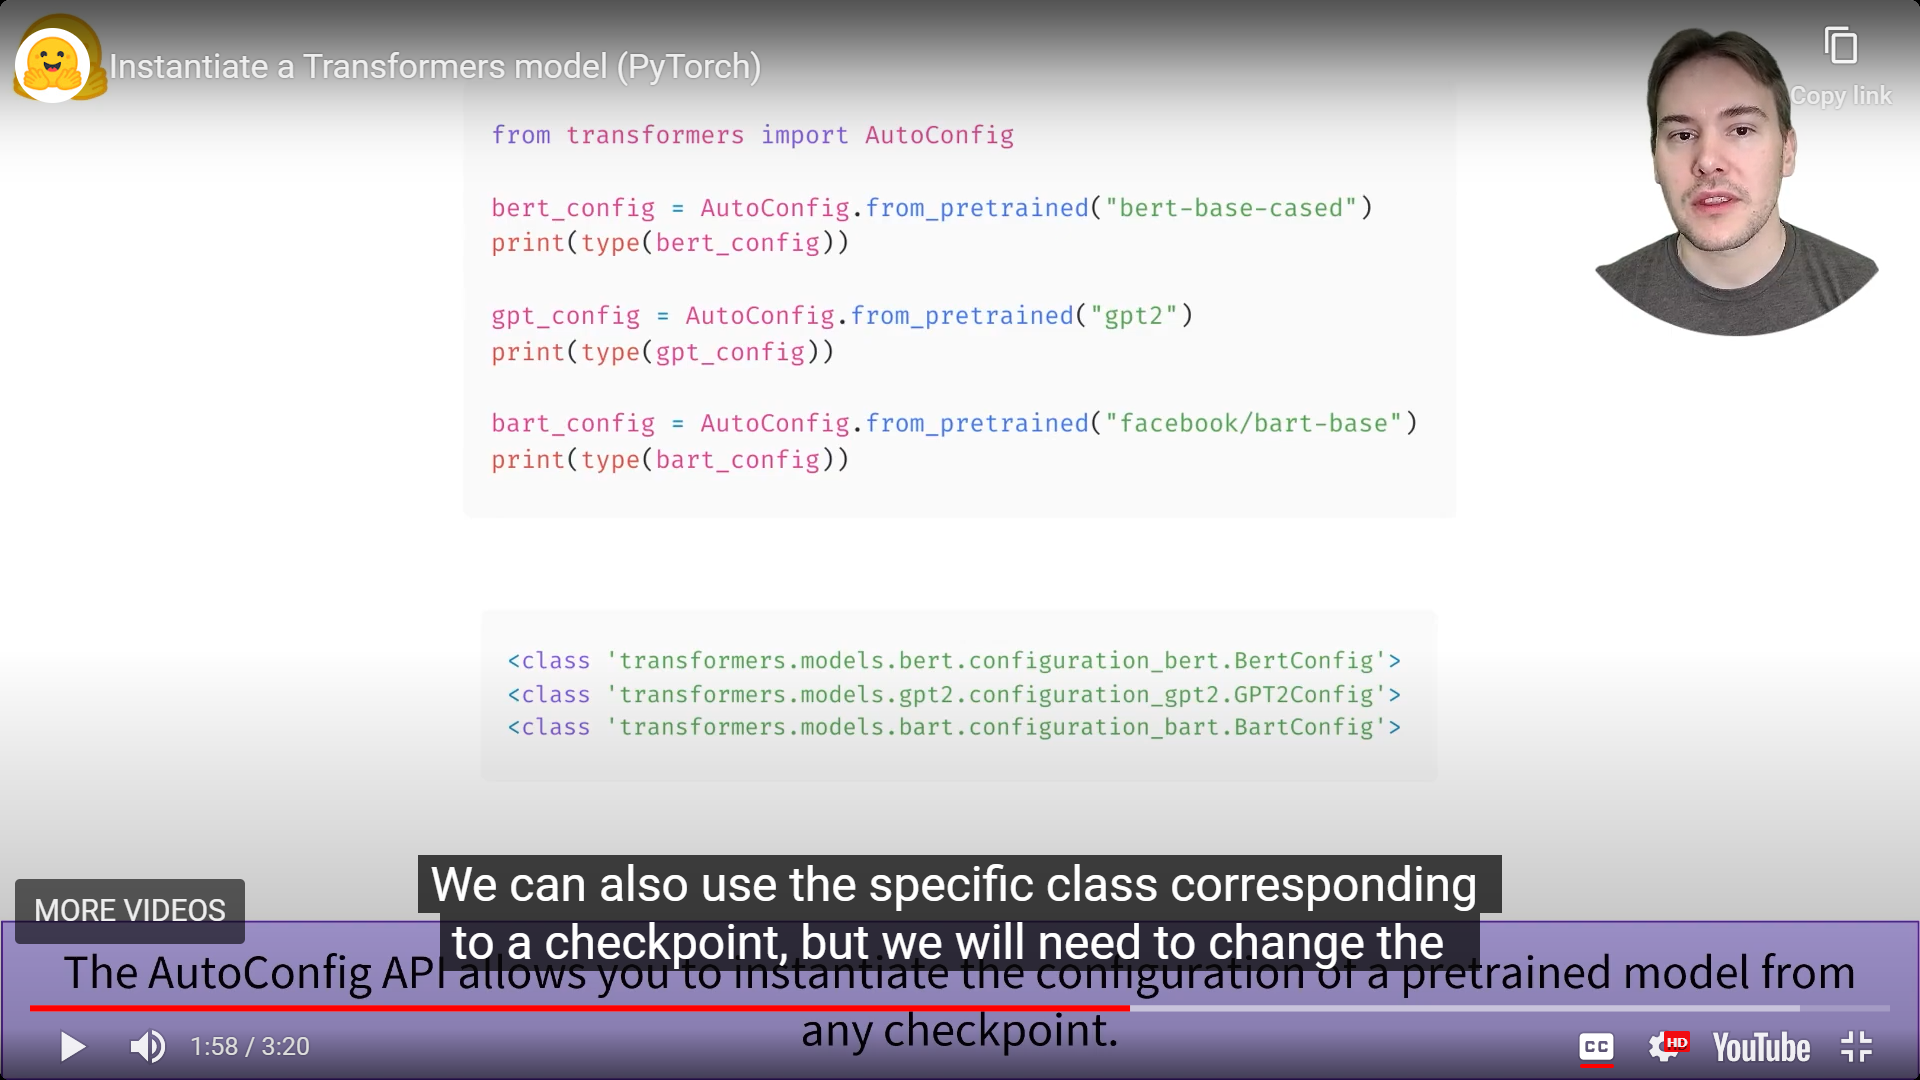

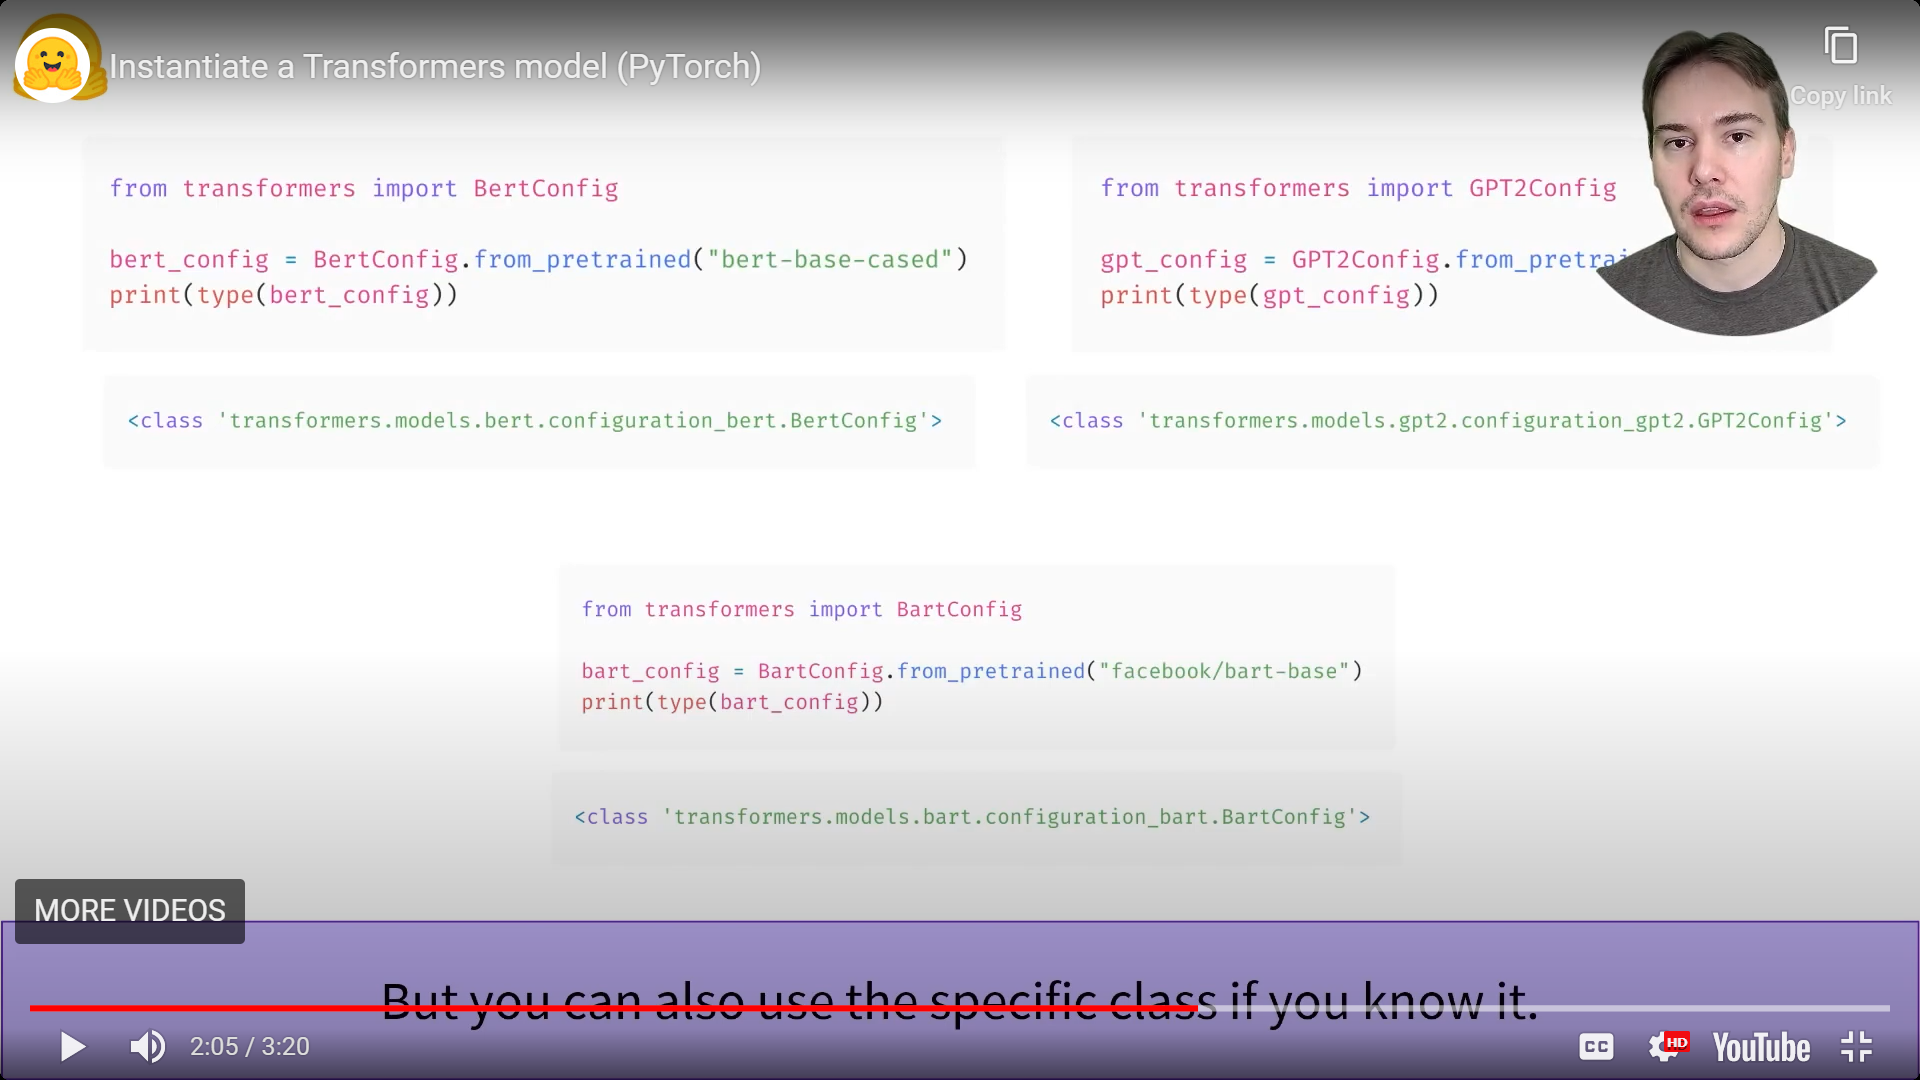

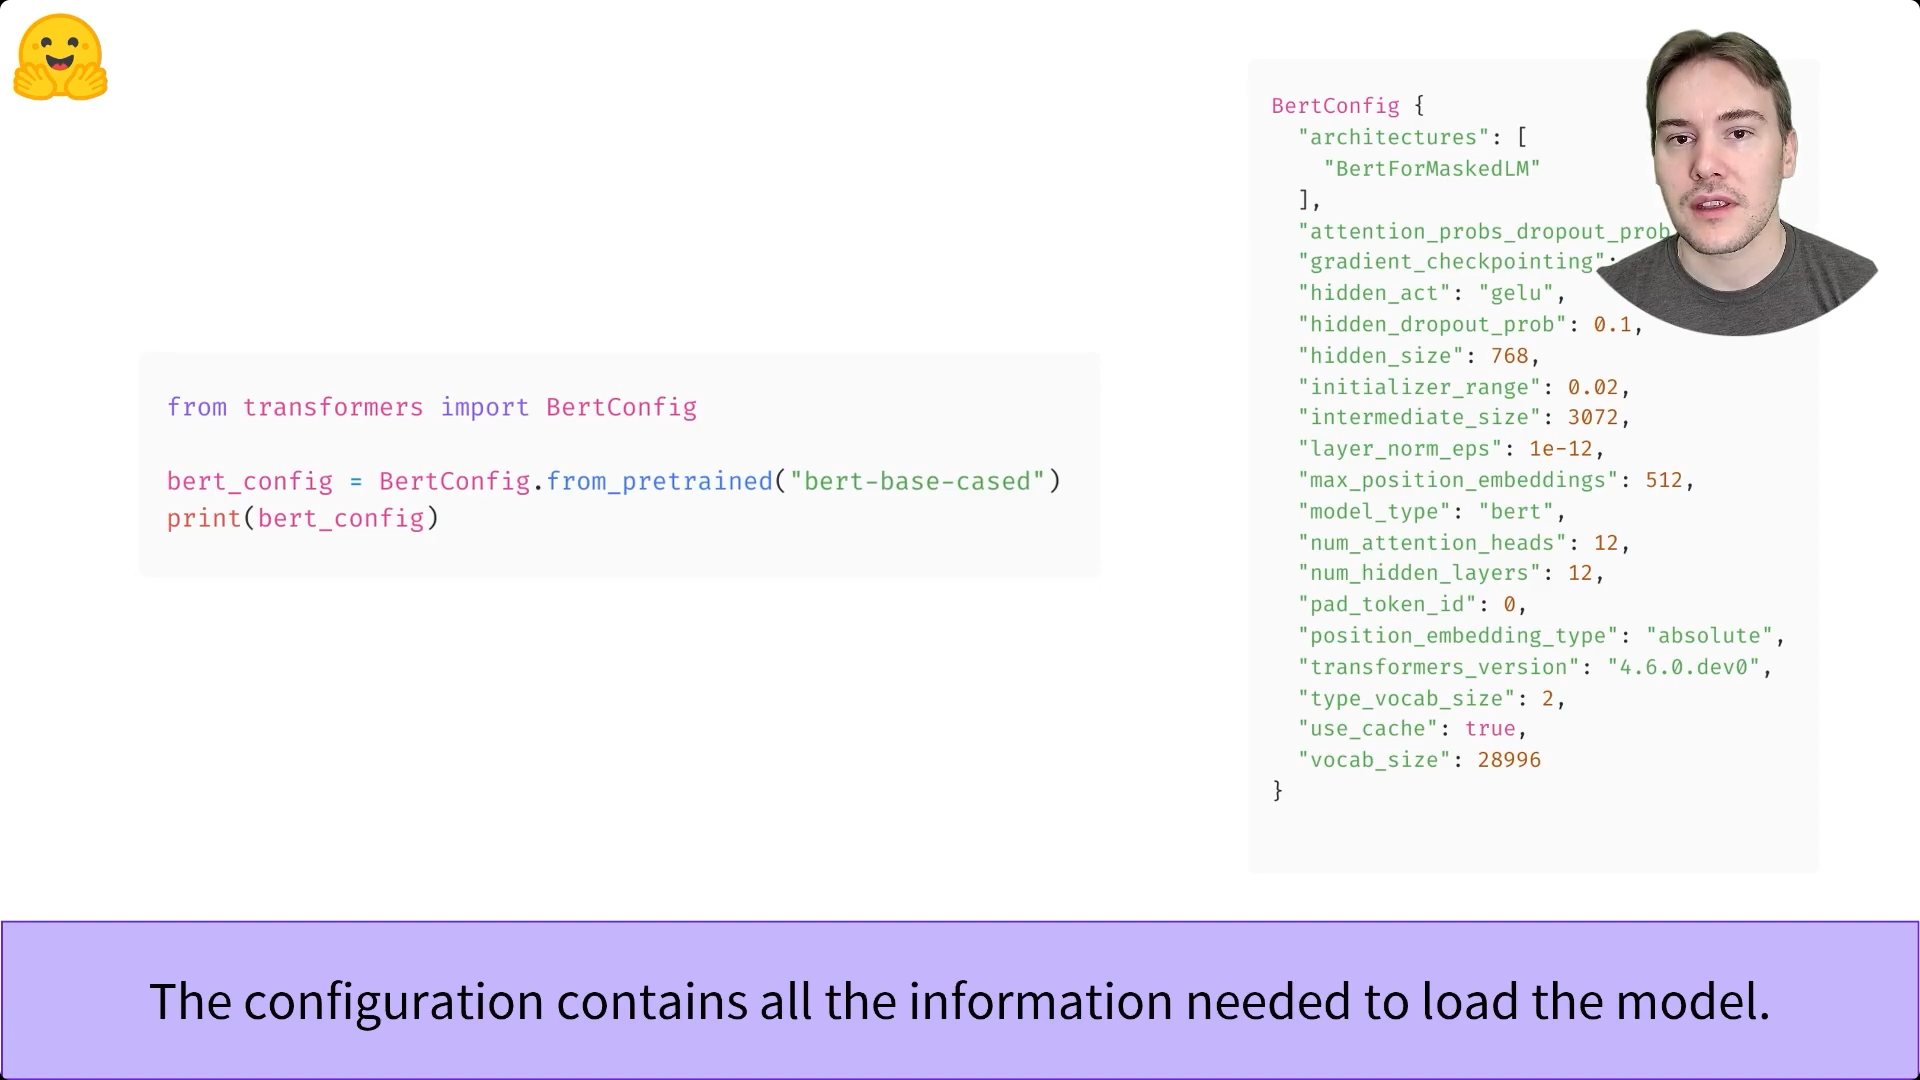

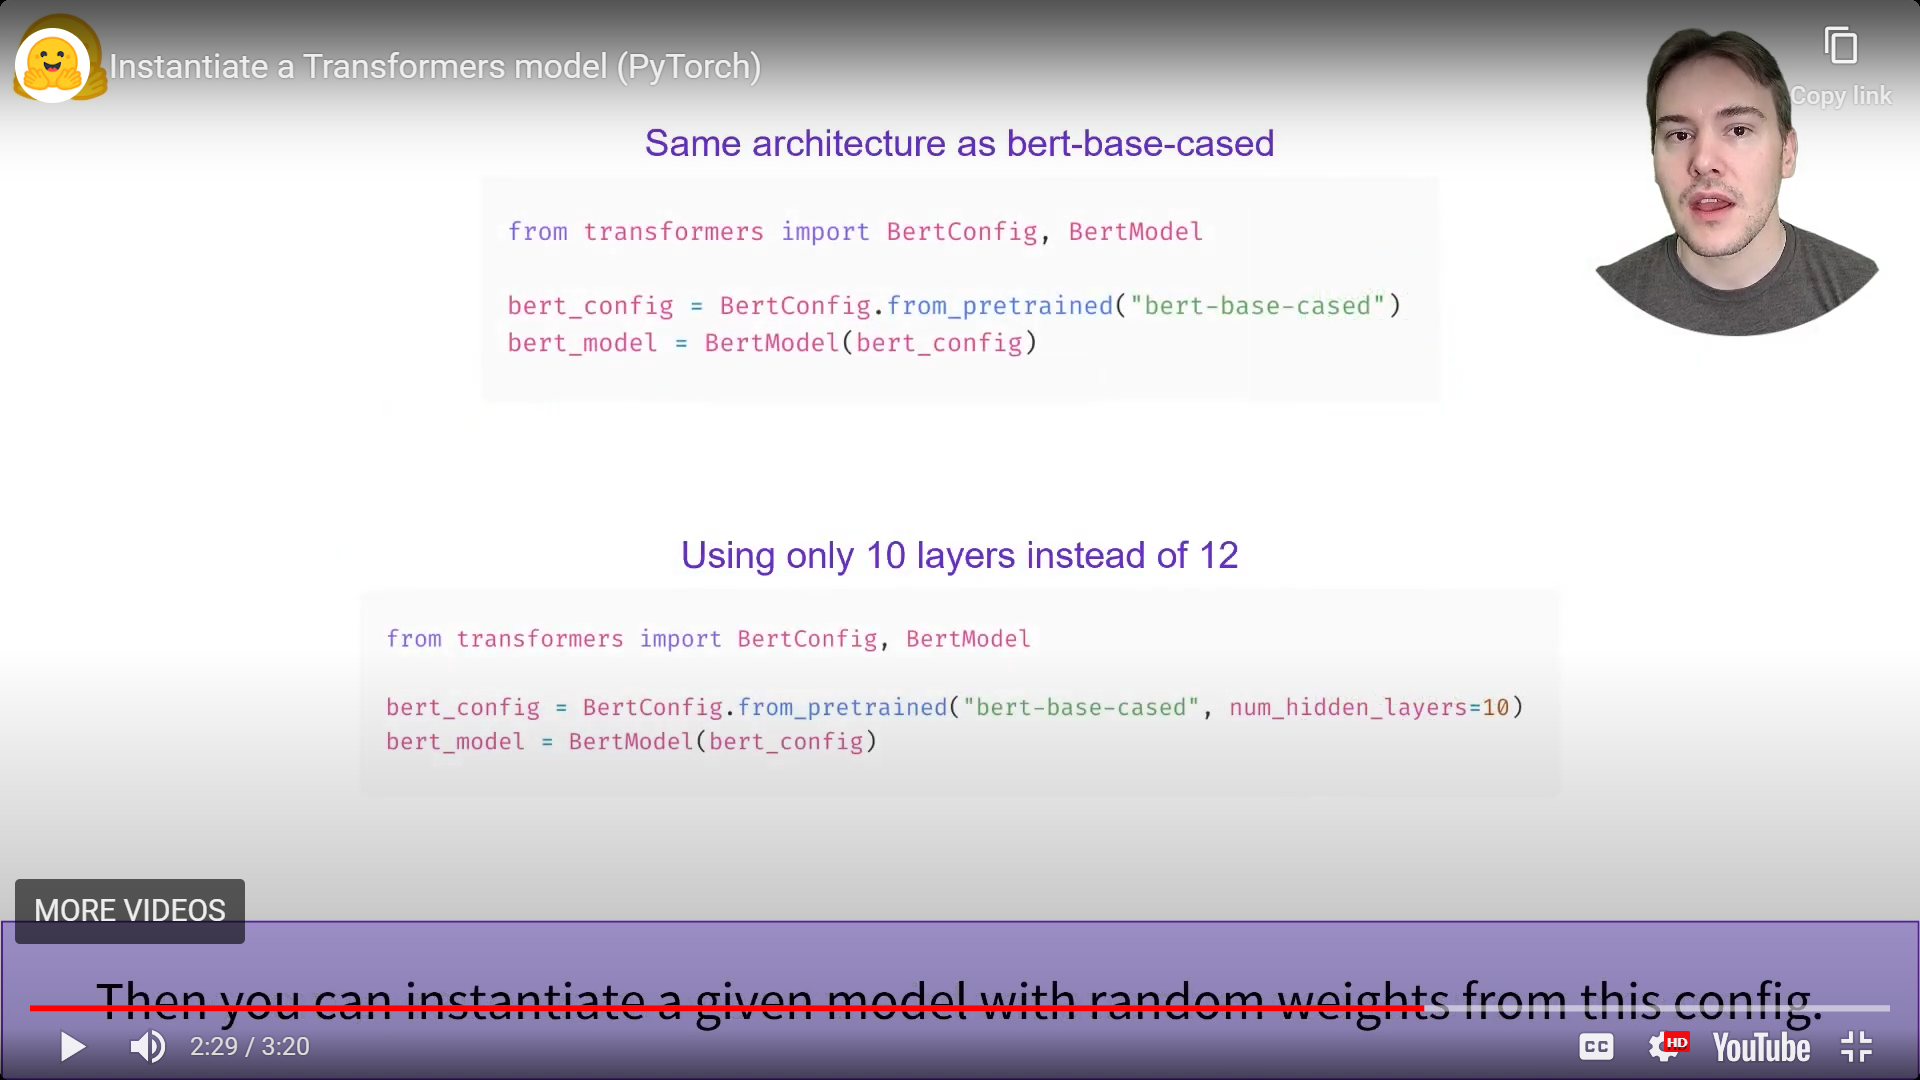

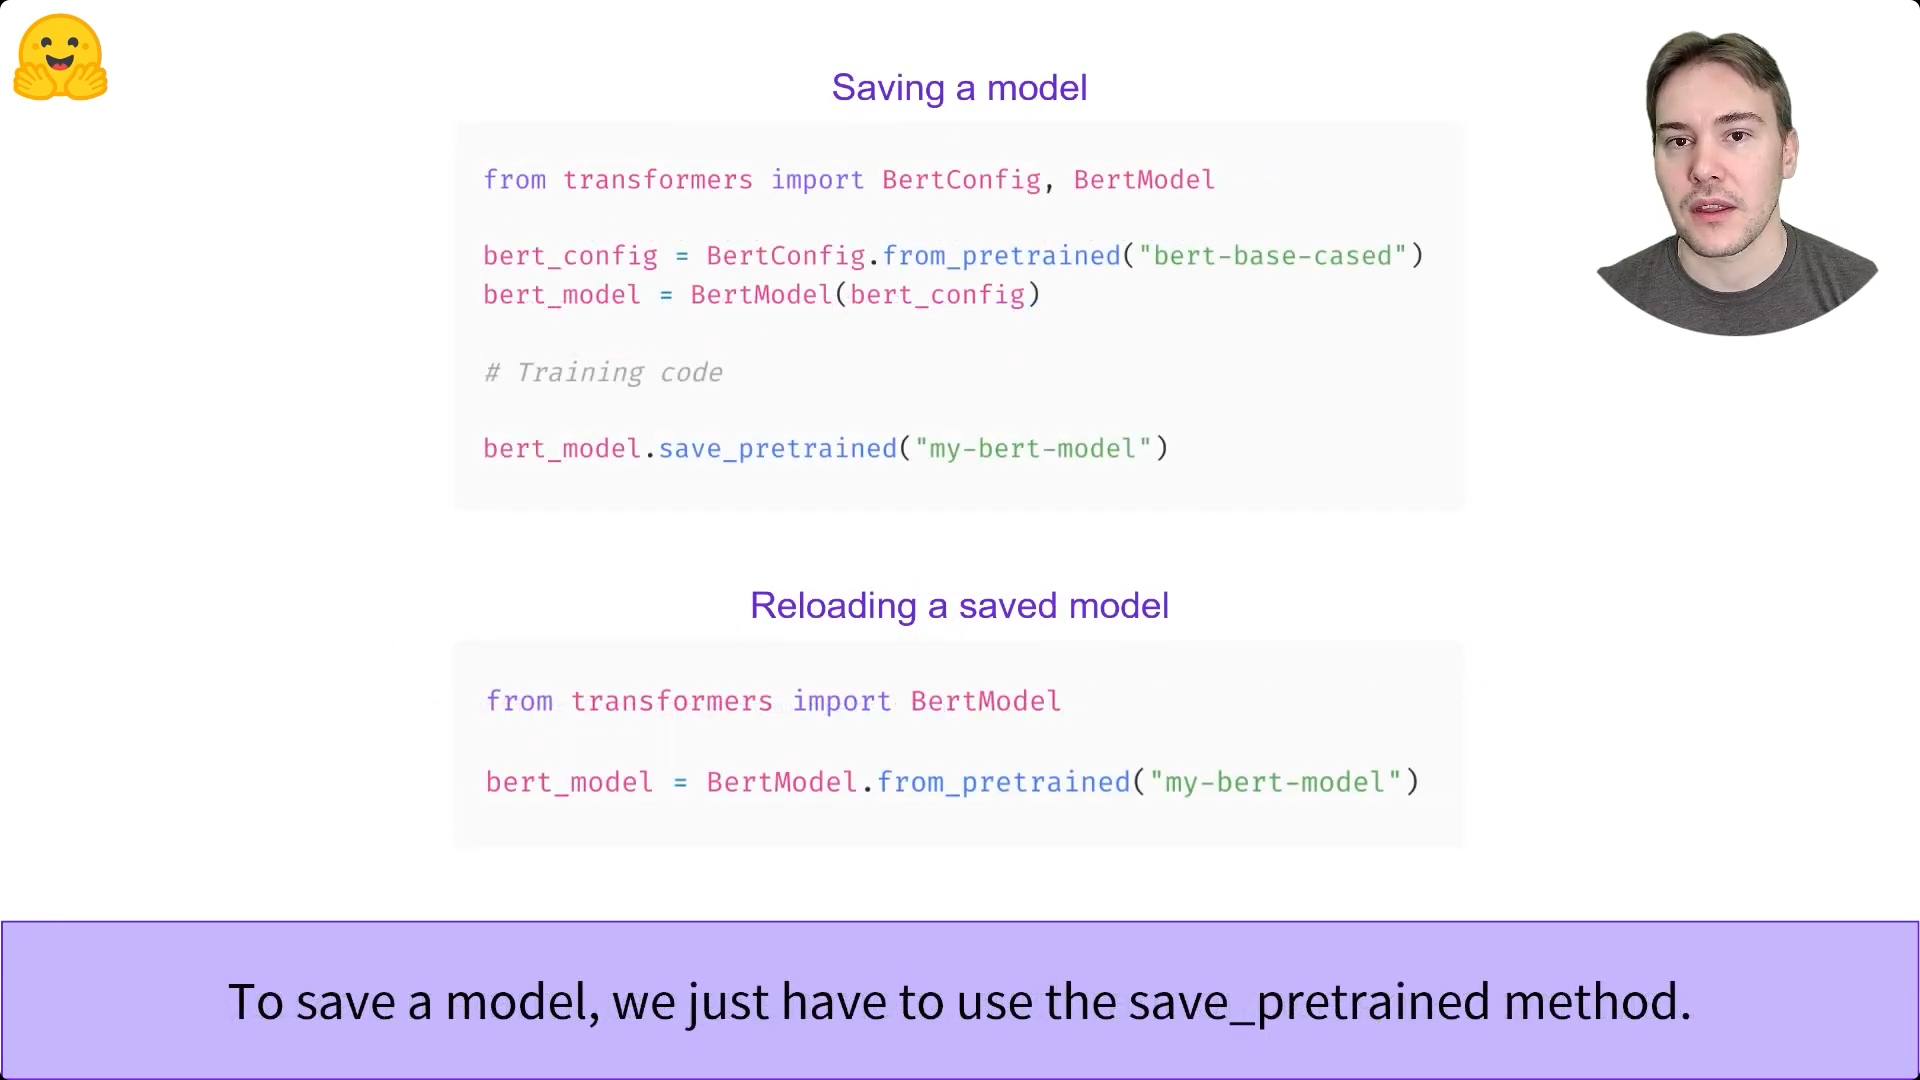

In [10]:
output = model(model_inputs)

#Tokenizers

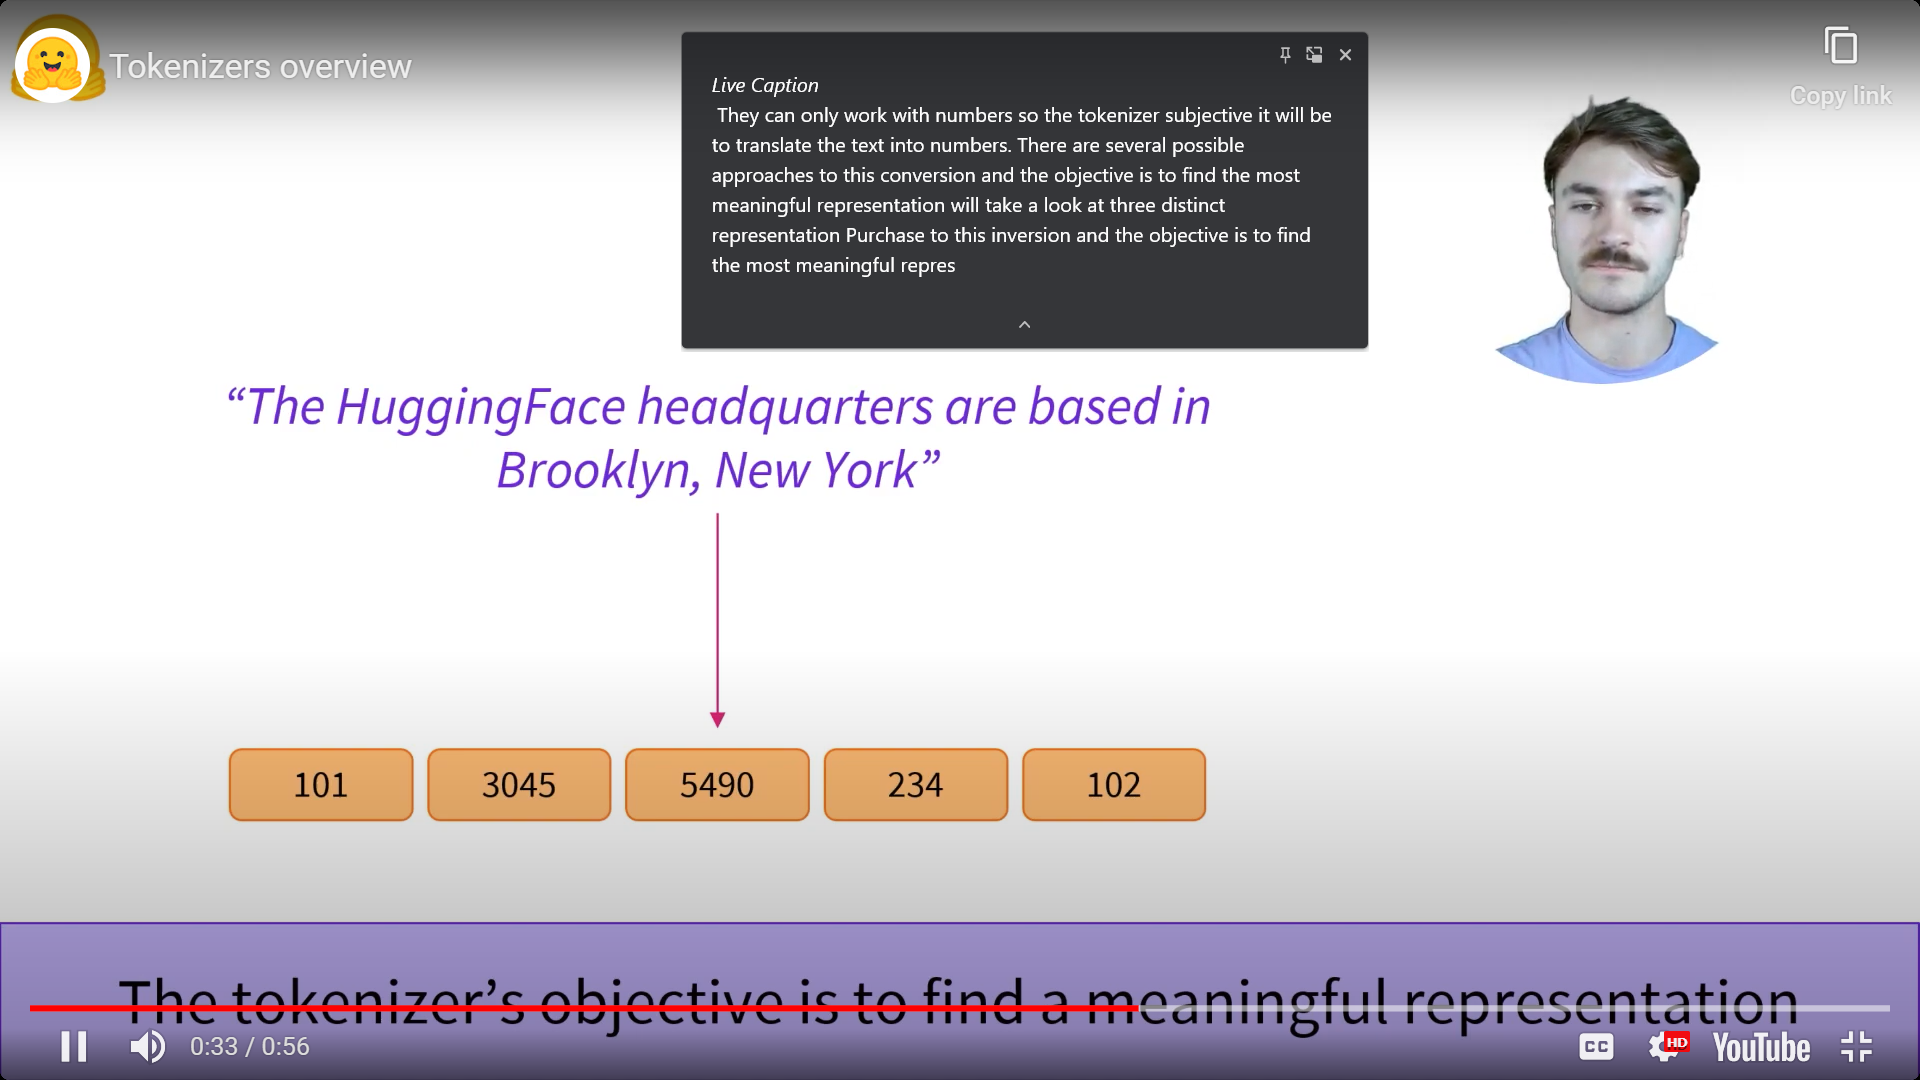

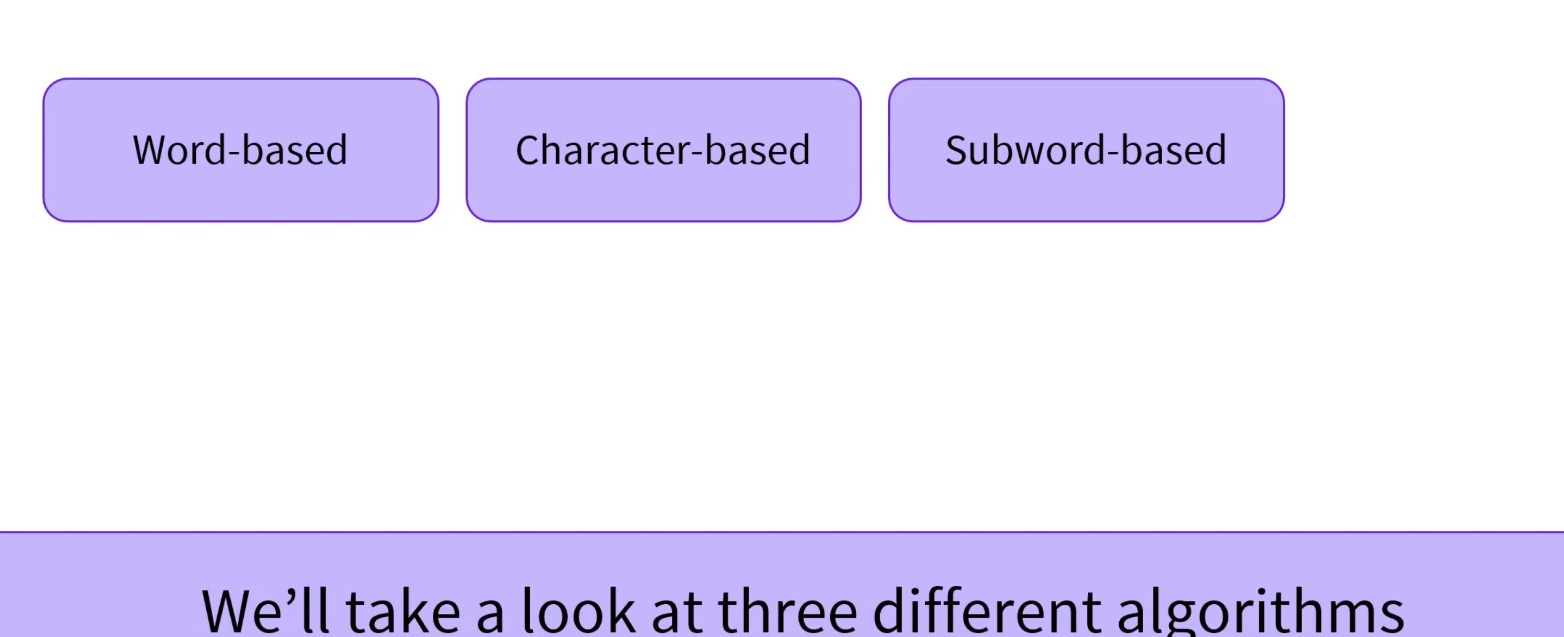

In [1]:
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)

['Jim', 'Henson', 'was', 'a', 'puppeteer']


In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Similar to AutoModel, the AutoTokenizer class will grab the proper tokenizer class in the library based on the checkpoint name, and can be used directly with any checkpoint:

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [5]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [6]:
tokenizer.save_pretrained("directory_on_my_computer")

('directory_on_my_computer/tokenizer_config.json',
 'directory_on_my_computer/special_tokens_map.json',
 'directory_on_my_computer/vocab.txt',
 'directory_on_my_computer/added_tokens.json',
 'directory_on_my_computer/tokenizer.json')